In [22]:
import os
import pandas as pd
import sys
import numpy as np
sys.path.append('/uge_mnt/home/tim_ivanov/pythonlibs/seaborn/seaborn')
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import operator
#!/conda_root/bin/conda install -yc anaconda statsmodels
from statsmodels.sandbox.stats.multicomp import multipletests

In [23]:
spb=pd.read_csv('spb.csv')
mw=pd.read_csv('mw.csv')


In [24]:
mw_samples='/uge_mnt/home/agalicina/2018/AdvancedBioLab/mw/moscow_samples.csv'
spb_samples='/uge_mnt/home/agalicina/2018/AdvancedBioLab/spb/stpetersburg_samples.csv'

with open(mw_samples) as f:
    s=f.readlines()
s=map(lambda x:x.split(','),s[1:])
mw_dic={}
for i in s:
    mw_dic[i[0]]=i[4].rstrip()

with open('mw.csv') as f:
    s=f.readlines()
s=map(lambda x:x.split(','),s)
mw=[]
mw.append(['group']+s[0][1:])
for i in s[1:]:
    mw.append([mw_dic[i[1]]]+i[1:])

mw_samples='/uge_mnt/home/agalicina/2018/AdvancedBioLab/mw/moscow_samples.csv'
spb_samples='/uge_mnt/home/agalicina/2018/AdvancedBioLab/spb/stpetersburg_samples.csv'

with open(spb_samples) as f:
    s=f.readlines()
s=map(lambda x:x.split(','),s[1:])
spb_dic={}
for i in s:
    spb_dic[i[0]]=i[4].rstrip()

with open('spb.csv') as f:
    s=f.readlines()
s=map(lambda x:x.split(','),s)
spb=[]
spb.append(['group']+s[0][1:])
for i in s[1:]:
    spb.append([spb_dic[i[1]]]+i[1:])



In [25]:
df=pd.DataFrame(mw[1:])
df.columns=mw[0]


In [26]:
peaks=filter(lambda x: x.startswith('peak'),list(df.columns))

pvalues=[]
for peak in peaks:
    peak_array=df['group']+' '+df[peak]
    peak_array=map(lambda x:x.split(),peak_array)
    gr1,gr2=[],[]
    for j in peak_array:
        if j[0]=='group1':
            gr1.append(float(j[1]))
        if j[0]=='group2':
            gr2.append(float(j[1]))
    pvalues.append([peak]+[float(stats.ttest_ind(gr1,gr2,equal_var=True)[1])])
print len(pvalues)

df = pd.DataFrame(columns=['peak','mw_p_value'])
for i in pvalues:
    df=df.append({'peak':i[0],'mw_p_value':i[1]},ignore_index=True)

df_s=df.sort_values(by=['mw_p_value'])

p_adjusted = multipletests(df_s.mw_p_value,alpha=0.05,is_sorted=True, method='fdr_bh')
print len(p_adjusted[1])
df_s['mw_p_adjusted']=p_adjusted[1]
df_s.head()
df_s.to_csv('Moscow_signf.csv', sep='\t',index=False)

11209
11209


In [27]:
df=pd.DataFrame(spb[1:])
df.columns=spb[0]

In [28]:
peaks=filter(lambda x: x.startswith('peak'),list(df.columns))

pvalues=[]
for peak in peaks:
    peak_array=df['group']+' '+df[peak]
    peak_array=map(lambda x:x.split(),peak_array)
    gr1,gr2=[],[]
    for j in peak_array:
        if j[0]=='group1':
            gr1.append(float(j[1]))
        if j[0]=='group2':
            gr2.append(float(j[1]))
    pvalues.append([peak]+[float(stats.ttest_ind(gr1,gr2,equal_var=True)[1])])
print len(pvalues)

df = pd.DataFrame(columns=['peak','spb_p_value'])
for i in pvalues:
    df=df.append({'peak':i[0],'spb_p_value':i[1]},ignore_index=True)

df_s=df.sort_values(by=['spb_p_value'])

p_adjusted = multipletests(df_s.spb_p_value,alpha=0.05,is_sorted=True, method='fdr_bh')
print len(p_adjusted[1])
df_s['spb_p_adjusted']=p_adjusted[1]
df_s.head()
df_s.to_csv('spb_signf.csv', sep='\t',index=False)

11042
11042


In [29]:
with open('spb_signf.csv') as f:
    spb_signf=f.readlines()
spb_signf=map(lambda x:x.split('\t'),spb_signf)

with open('Moscow_signf.csv') as f:
    mw_signf=f.readlines()
mw_signf=map(lambda x:x.split('\t'),mw_signf)

print 'Moscow:\n'
print filter(lambda x:x[0]=='peak1013',mw_signf)[0]
print 'Spb:\n'
print filter(lambda x:x[0]=='peak1013',spb_signf)[0]

dfm = pd.read_csv('Moscow_signf.csv',sep='\t')
dfp = pd.read_csv('spb_signf.csv',sep='\t')

df = pd.merge(left=dfm,right=dfp, left_on='peak', right_on='peak')
#df.to_csv('All_pvalues_matched_by_peak.csv', sep='\t',index=False)

df_intersect=df.loc[df['mw_p_adjusted']<0.05]
df_intersect=df_intersect.loc[df['spb_p_adjusted']<0.05]
print len(df_intersect)
#df_intersect.to_csv('Intersection_matched_by_peak.csv', sep='\t',index=False)

colors = list(df.apply(lambda x: 'red' if 
         (np.abs(x.mw_p_adjusted-x.spb_p_adjusted)<0.01)&(x.spb_p_adjusted<0.05)&(x.mw_p_adjusted<0.05) 
         else 'blue', axis=1).values)



Moscow:

['peak1013', '1.1500751169179863e-18', '1.2891191985533709e-14\n']
Spb:

['peak1013', '2.056537603959059e-06', '3.1451922746420954e-05\n']
1577


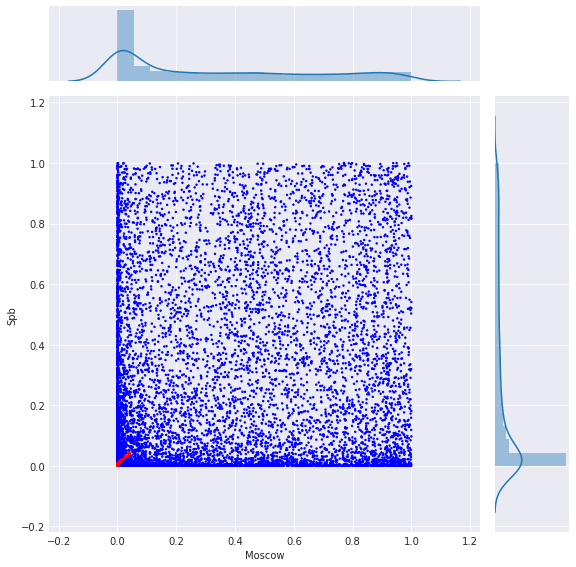

In [32]:
with sns.axes_style('darkgrid'):
    g = sns.jointplot("mw_p_adjusted","spb_p_adjusted", df, kind="reg",size=8)
    #g.ax_joint.scatter(df.mw_p_adjusted,df.spb_p_adjusted)
    g.ax_joint.cla()
    plt.sca(g.ax_joint)
    plt.scatter(df.mw_p_adjusted, df.spb_p_adjusted, c=colors, s=2)
    plt.xlabel('Moscow')
    plt.ylabel('Spb')

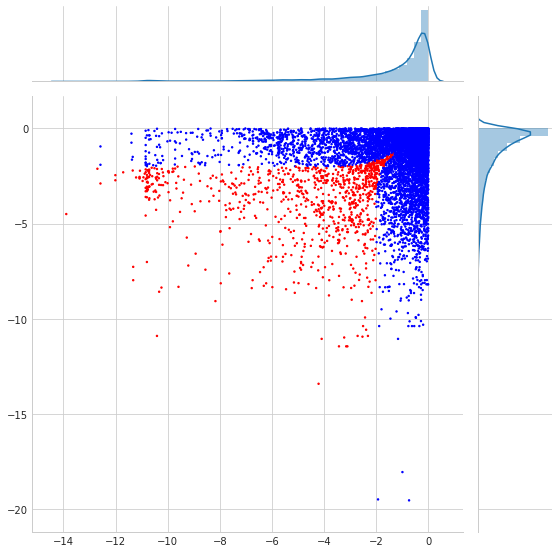

In [31]:
df_log = df.copy()
df_log.iloc[:,1:] = np.log10(df.iloc[:,1:].values)
with sns.axes_style('whitegrid'):
    g = sns.jointplot("mw_p_adjusted","spb_p_adjusted", df_log, kind="reg",size=8)
    #g.ax_joint.scatter(df.mw_p_adjusted,df.spb_p_adjusted)
    g.ax_joint.cla()
    plt.sca(g.ax_joint)
    plt.scatter(df_log.mw_p_adjusted, df_log.spb_p_adjusted, c=colors, s=2)